Reference: 
* https://www.kaggle.com/code/springboardroger/naive-bayes-name-gender-classifier
* https://www.kaggle.com/code/ynouri/random-forest-k-fold-cross-validation 
* https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neural_network 

Here, we import all of the needed libraries. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import matplotlib
matplotlib.use("TKAgg")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
matplotlib.rcParams.update({'font.family': "Open Sans", 'font.size': 16})


In [2]:
import helper

## Exploratory Data Analysis

Now we import the data file (the Social Security database) and do some basic data cleaning -- so we can display the first five entries and get a sense of the data.

In [3]:
names = pd.read_csv("data/name_gender.csv")
names["name"] = names["name"].apply(lambda x: x.lower())
names


names = names[:100]
names

,name,gender
0,aaban&&,M
1,aabha*,F
2,aabid,M
3,aabriella,F
4,aada_,F
...,...,...
95,aaleiah,F
96,aaleigha,F
97,aaleiyah,F
98,aalena,F


In [4]:
names.isnull().groupby("name").count()


,gender
name,
False,100


In [5]:
names.isnull().groupby("gender").count()


,name
gender,
False,100


no missing data for each row

### Check non-alphabetic character

In [6]:
names["is_alphabet"] = names["name"].apply(helper.is_alphabet)
names[names["is_alphabet"] == False]

,name,gender,is_alphabet
0,aaban&&,M,False
1,aabha*,F,False
4,aada_,F,False
10,aadhav+,M,False
13,aadhira4,F,False
17,aadi[],M,False
23,aadit4,M,False
25,aadithya;,M,False
32,aadrit*,M,False
57,aaira89,F,False


there are punctuation and number from names that should be removed

## Data Cleaning

* Lowercase
* Remove Punctuation
* Remove Number
 

In [7]:
names["name"] = names.apply(lambda row: helper.remove_punctuation(row["name"].lower()), axis=1)
names["name"] = names.apply(lambda row: helper.remove_number(row["name"]), axis=1)
names

,name,gender,is_alphabet
0,aaban,M,False
1,aabha,F,False
2,aabid,M,True
3,aabriella,F,True
4,aada,F,False
...,...,...,...
95,aaleiah,F,True
96,aaleigha,F,True
97,aaleiyah,F,True
98,aalena,F,True


Now let's groupby so we can get away from counting, and get the aggregated count of female and male occurrences for each name.

In [8]:
names.groupby(['name', 'gender']).size().reset_index(name='count').sort_values(by=["count", "name", "gender"])


,name,gender,count
0,aaban,M,1
1,aabha,F,1
2,aabid,M,1
3,aabriella,F,1
4,aada,F,1
...,...,...,...
95,aaleiah,F,1
96,aaleigha,F,1
97,aaleiyah,F,1
98,aalena,F,1


Each name is unique and only has one occurence in the dataset. Since each name only has 1 occurence, there is not any frequency information of a specific name.

### Gender Distribution

In [9]:
names.groupby(['gender']).count()


,name,is_alphabet
gender,,
F,58,58
M,42,42


The number of females name almost 2x time higher than the number of male names. 
Thus, during inferencing, it's better to give female prediction as the ouput when the queried name is not exist in the training data. 

### Name Length

In [10]:
names["length"] = names["name"].apply(len)
names


,name,gender,is_alphabet,length
0,aaban,M,False,5
1,aabha,F,False,5
2,aabid,M,True,5
3,aabriella,F,True,9
4,aada,F,False,4
...,...,...,...,...
95,aaleiah,F,True,7
96,aaleigha,F,True,8
97,aaleiyah,F,True,8
98,aalena,F,True,6


In [11]:
names[names["gender"] == "F"].groupby("length").count()


,name,gender,is_alphabet
length,,,
4,3,3,3
5,11,11,11
6,10,10,10
7,20,20,20
8,12,12,12
9,2,2,2


In [12]:
names[names["gender"] == "M"].groupby("length").count()


,name,gender,is_alphabet
length,,,
4,2,2,2
5,18,18,18
6,14,14,14
7,6,6,6
8,2,2,2


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


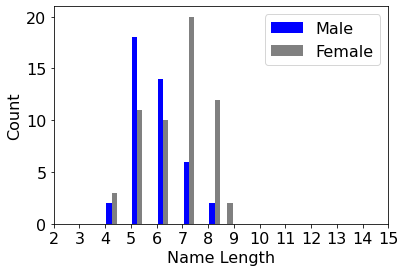

In [13]:
import matplotlib.pyplot as plt

male_lengths = names[names["gender"] == "M"]["length"]
female_lengths = names[names["gender"] == "F"]["length"]

plt.hist([male_lengths, female_lengths], color=[
         'Blue', 'Grey'], label=['Male', 'Female'])
plt.xlabel('Name Length')
plt.xticks(range(2,16))
plt.ylabel('Count')
plt.legend()
plt.show()

## Feature Representation

### Bag of Words
Machine learning models don't learn from raw text data. Instead, you need to convert the text to something numeric.

The simplest common representation is a variation of one-hot encoding. You represent each document as a vector of term frequencies for each term in the vocabulary. The vocabulary is built from all the tokens (terms) in the corpus (the collection of documents). 

As an example, take the sentences "Tea is life. Tea is love." and "Tea is healthy, calming, and delicious." as our corpus. The vocabulary then is `{"tea", "is", "life", "love", "healthy", "calming", "and", "delicious"}` (ignoring punctuation).

For each document, count up how many times a term occurs, and place that count in the appropriate element of a vector. The first sentence has "tea" twice and that is the first position in our vocabulary, so we put the number 2 in the first element of the vector. Our sentences as vectors then look like 

$$
\begin{align}
v_1 &= \left[\begin{matrix} 2 & 2 & 1 & 1 & 0 & 0 & 0 & 0 \end{matrix}\right] \\
v_2 &= \left[\begin{matrix} 1 & 1 & 0 & 0 & 1 & 1 & 1 & 1 \end{matrix}\right]
\end{align}
$$

This is called the **bag of words** representation. You can see that documents with similar terms will have similar vectors. Vocabularies frequently have tens of thousands of terms, so these vectors can be very large.

Another common representation is **TF-IDF (Term Frequency - Inverse Document Frequency)**. TF-IDF is similar to bag of words except that each term count is scaled by the term's frequency in the corpus. Using TF-IDF can potentially improve your models. You won't need it here. Feel free to look it up though!


#### Bi-gram analysis

<AxesSubplot:>

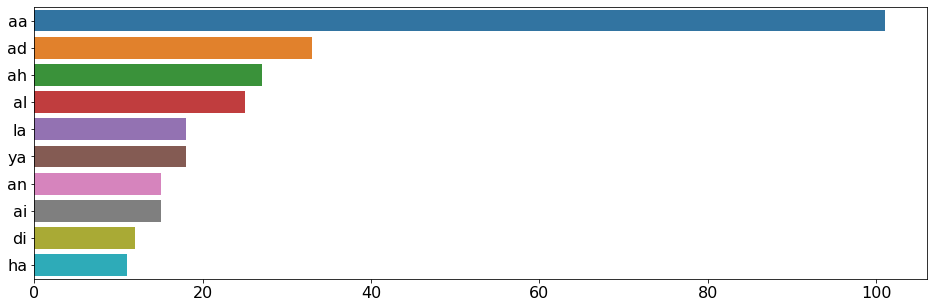

In [14]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(analyzer='char', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(names['name'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


<AxesSubplot:>

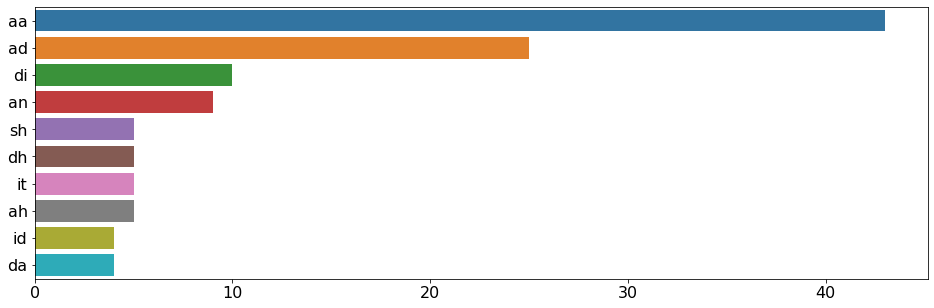

In [15]:
male_names = names[names['gender']=="M"]['name']

plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(male_names)[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


<AxesSubplot:>

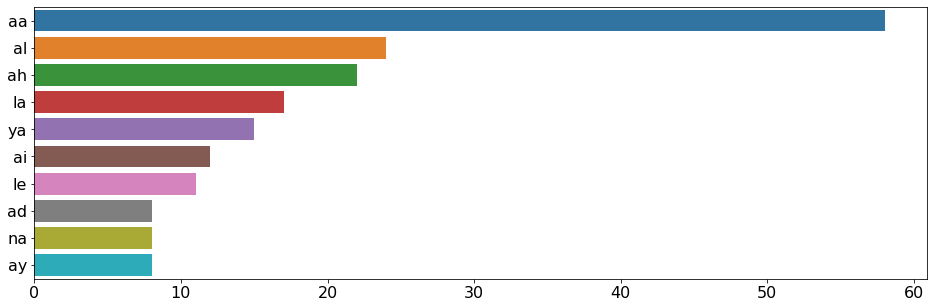

In [16]:
female_names = names[names['gender'] == "F"]['name']

plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(female_names)[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


### Bigram Feature


TODO: handle out of vocubalary by adding dummy value for fit() function

In [17]:
def countvect(data):
    count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer


cv_features, count_vectorizer = countvect(names["name"])
# count_vectorizer.get_feature_names()


In [18]:
# print(cv_features.toarray())
# print(cv_features.toarray()[0])


### TF-IDF

In [19]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


tfidf_features, tfidf_vectorizer = tfidf(names["name"])


In [20]:
# print(tfidf_feature.toarray())
# print(tfidf_features.toarray()[0])


In [21]:
print(len(tfidf_features.toarray()[0]))
print(len(tfidf_vectorizer.get_feature_names()))


105
105


## Classifier

In [22]:

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score


In [23]:
def plot_roc_curve(fprs, tprs, name):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    # f, ax = plt.subplots(figsize=(7,5))
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {name}')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(clf, X, y, index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score


def compute_accuracy(clf, X, y, index):
    y_predict = clf.predict(X.iloc[index])
    acc = accuracy_score(y.iloc[index], y_predict)
    return acc


## CountVec Feature

In [24]:
X = pd.DataFrame(data=cv_features.toarray(),
                 columns=tfidf_vectorizer.get_feature_names())
# X = pd.DataFrame(data=tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names())
y = names["gender"].apply(lambda x: 1 if x == "F" else 0)


In [25]:
rf_clf = RandomForestClassifier(
    n_estimators=700,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

knn_clf = KNeighborsClassifier(n_neighbors=5)
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
gaussian_clf = GaussianNB()

clfs = {
    "Gaussian": gaussian_clf, 
    "kNN": knn_clf, 
    "MLP": mlp_clf,
    "RandomForest": rf_clf
}


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


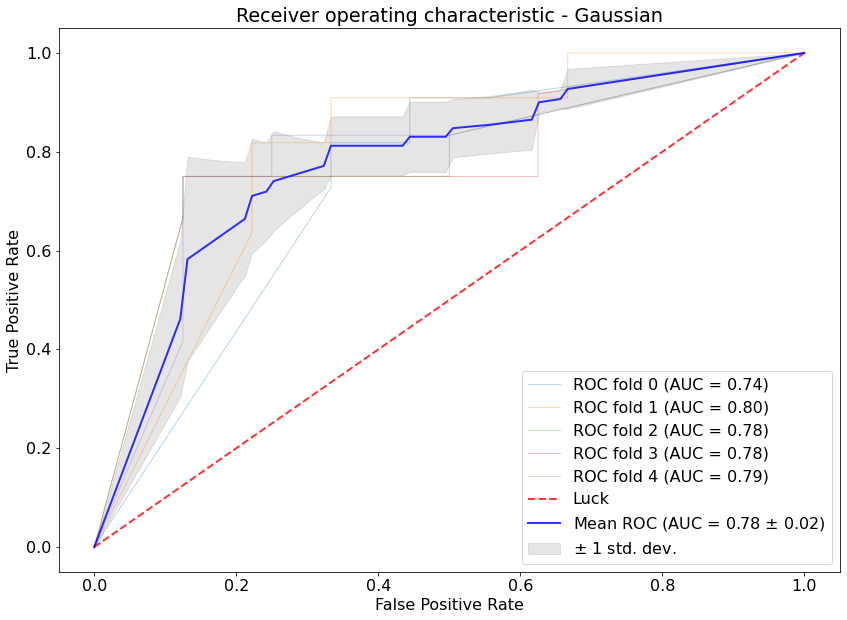

Performance of Gaussian
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.9375      0.70   0.986460  0.737374
1     0.9000      0.70   0.981947  0.797980
2     0.9250      0.75   0.986573  0.781250
3     0.9125      0.75   0.993606  0.776042
4     0.9250      0.60   0.998082  0.786458




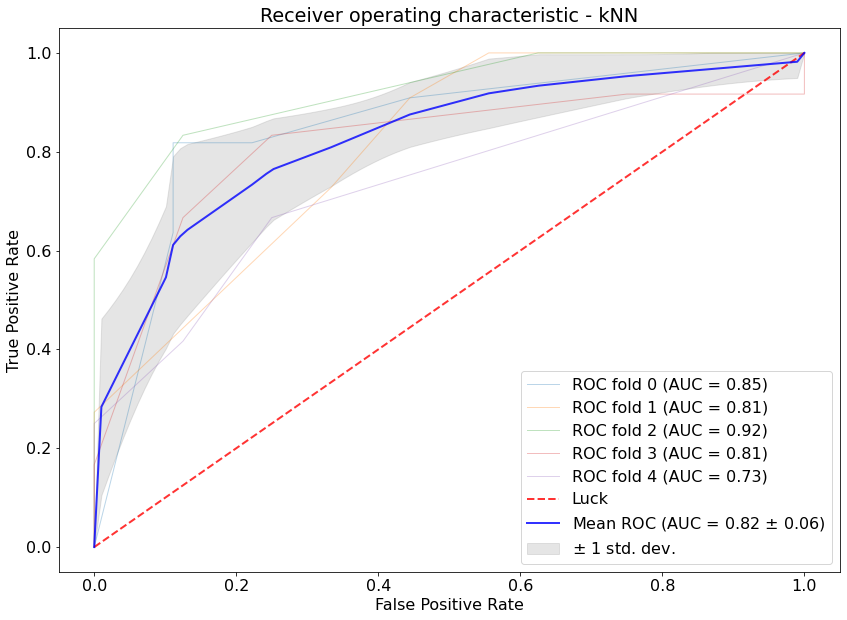

Performance of kNN
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.8500      0.80   0.908446  0.848485
1     0.8500      0.75   0.906512  0.808081
2     0.8500      0.85   0.906969  0.921875
3     0.8375      0.80   0.917519  0.812500
4     0.8875      0.60   0.956841  0.734375




/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

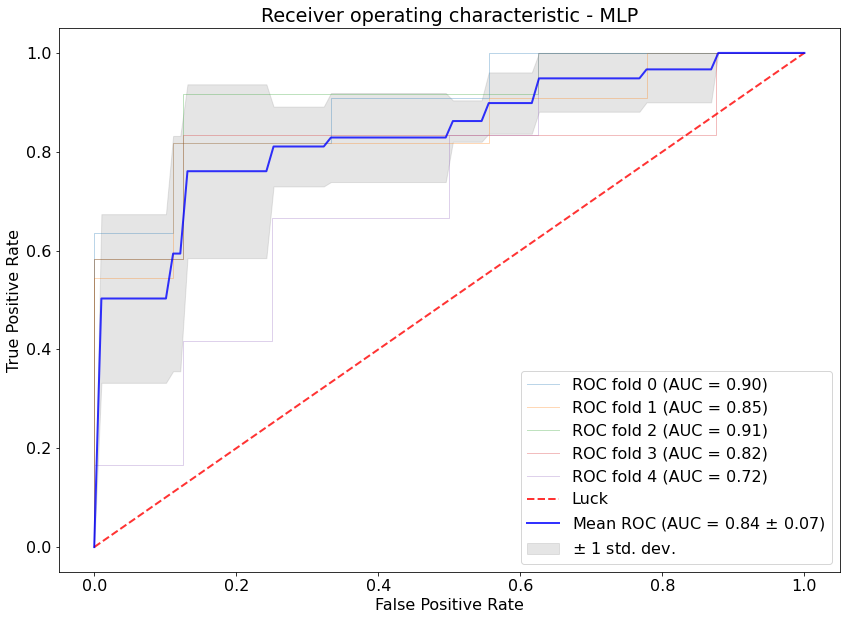

Performance of MLP
   Acc Train  Acc Test  AUC Train  AUC Test
0        1.0      0.80        1.0  0.898990
1        1.0      0.75        1.0  0.848485
2        1.0      0.80        1.0  0.906250
3        1.0      0.80        1.0  0.822917
4        1.0      0.70        1.0  0.718750




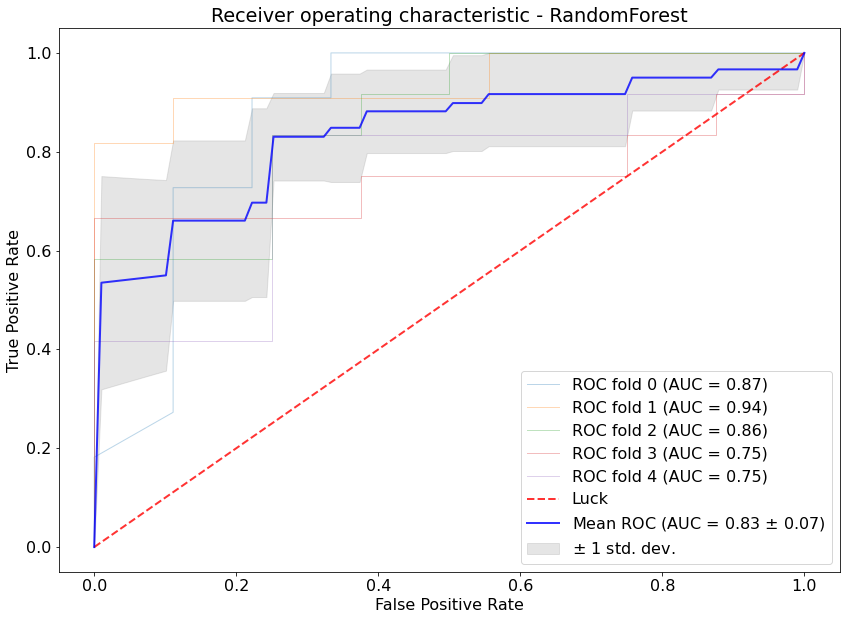

Performance of RandomForest
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.8750      0.80   0.969697  0.873737
1     0.9000      0.85   0.962605  0.939394
2     0.8750      0.65   0.966752  0.864583
3     0.9125      0.65   0.956522  0.750000
4     0.9000      0.55   0.975064  0.750000




In [26]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for clf_name, clf in clfs.items() :
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        acc_train = compute_accuracy(clf, X, y, train)
        acc = compute_accuracy(clf, X, y, test)
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((acc_train, acc, auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs, name=clf_name)
    result = pd.DataFrame(scores, columns=['Acc Train', 'Acc Test', 'AUC Train', 'AUC Test'])
    print(f"Performance of {clf_name}")
    print(result)
    print()
    print()


## TF-IDF Feature

In [27]:
X = pd.DataFrame(data=tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names())
y = names["gender"].apply(lambda x: 1 if x == "F" else 0)

In [28]:
rf_clf = RandomForestClassifier(
    n_estimators=700,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

knn_clf = KNeighborsClassifier(n_neighbors=5)
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
gaussian_clf = GaussianNB()

clfs = {
    "Gaussian": gaussian_clf, 
    "kNN": knn_clf, 
    "MLP": mlp_clf,
    "RandomForest": rf_clf
}


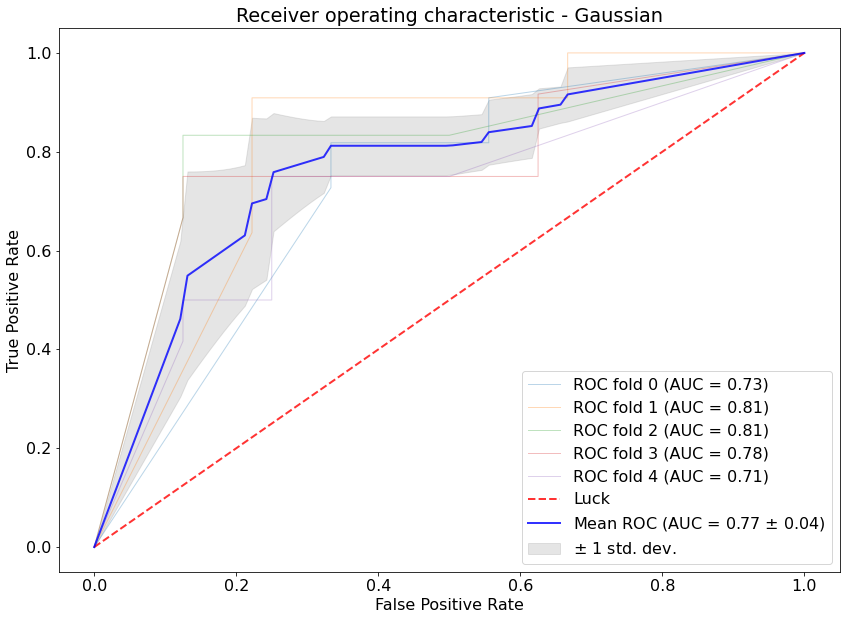

Performance of Gaussian
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.9375      0.70   0.990974  0.727273
1     0.9000      0.70   0.991618  0.808081
2     0.9250      0.75   0.992327  0.812500
3     0.9125      0.75   0.994246  0.776042
4     0.9250      0.60   0.999361  0.713542




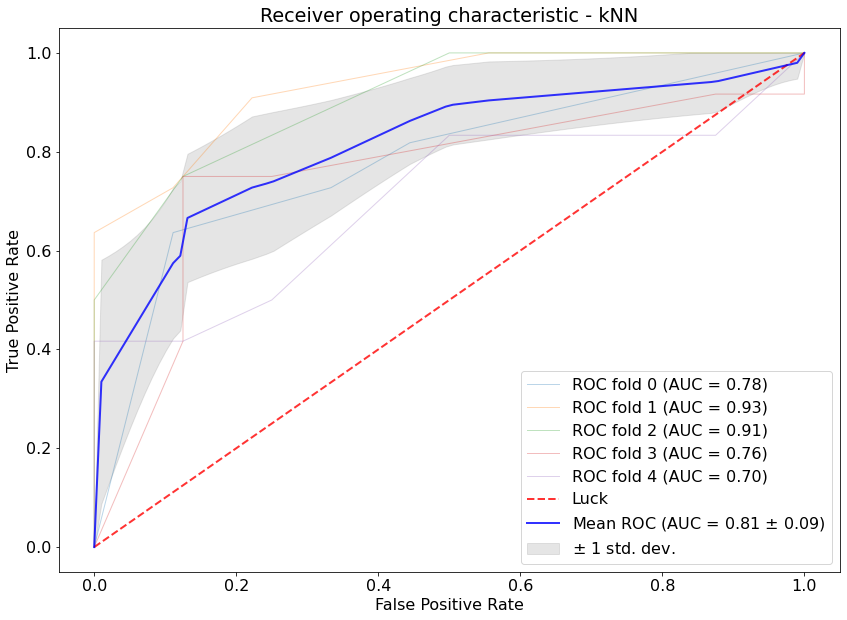

Performance of kNN
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.8125      0.70   0.900709  0.777778
1     0.8625      0.85   0.910380  0.929293
2     0.8125      0.80   0.875320  0.906250
3     0.8500      0.75   0.906330  0.755208
4     0.8500      0.60   0.928389  0.703125




/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

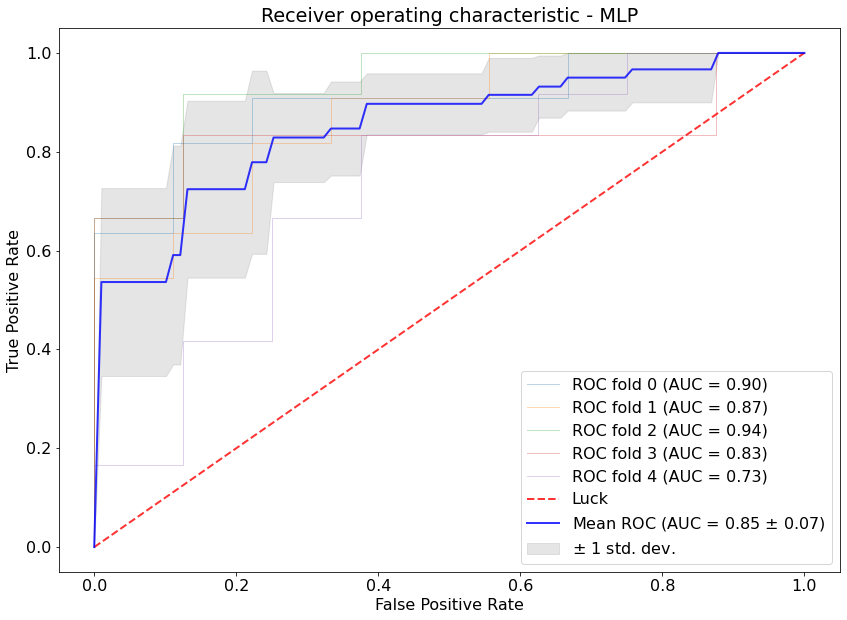

Performance of MLP
   Acc Train  Acc Test  AUC Train  AUC Test
0        1.0      0.80        1.0  0.898990
1        1.0      0.75        1.0  0.868687
2        1.0      0.75        1.0  0.937500
3        1.0      0.85        1.0  0.833333
4        1.0      0.70        1.0  0.729167




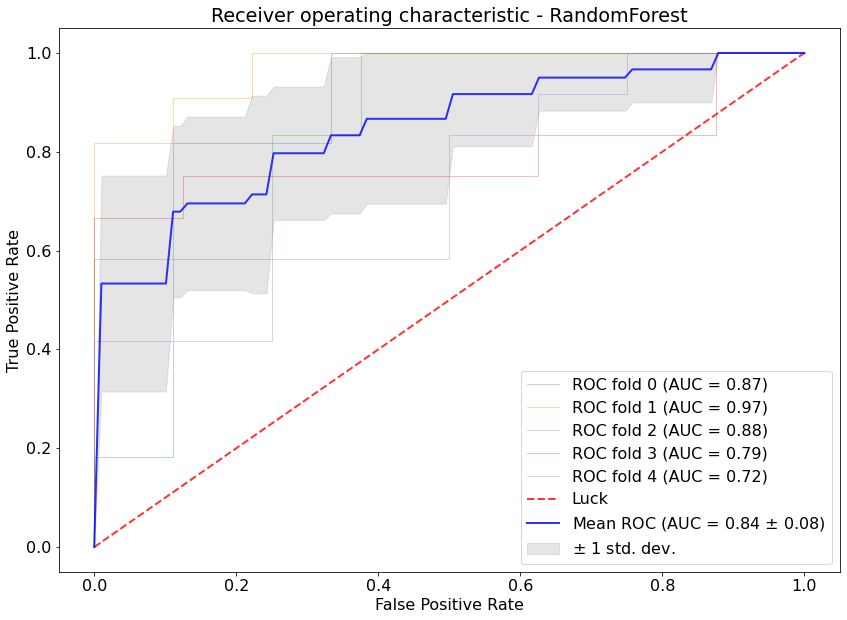

Performance of RandomForest
   Acc Train  Acc Test  AUC Train  AUC Test
0     0.9625      0.75   0.991618  0.868687
1     0.9625      0.85   0.983237  0.969697
2     0.9125      0.70   0.985934  0.875000
3     0.9250      0.65   0.980818  0.791667
4     0.9250      0.60   0.991688  0.718750




In [29]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

for clf_name, clf in clfs.items() :
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []
    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        acc_train = compute_accuracy(clf, X, y, train)
        acc = compute_accuracy(clf, X, y, test)
        _, _, auc_score_train = compute_roc_auc(clf, X, y, train)
        fpr, tpr, auc_score = compute_roc_auc(clf, X, y, test)
        scores.append((acc_train, acc, auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)

    plot_roc_curve(fprs, tprs, name=clf_name)
    result = pd.DataFrame(scores, columns=['Acc Train', 'Acc Test', 'AUC Train', 'AUC Test'])
    print(f"Performance of {clf_name}")
    print(result)
    print()
    print()
